In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys

%matplotlib inline

from functools import partial

### Import MNIST data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()    

In [4]:
def variable_summaries(var):
    """ Attach a lot of summaries to a Tensor (for TensorBoard visualization). """
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

### set parameters

In [5]:
learning_rate = 0.001

training_epochs = 50
batch_size = 200
display_step = 1
examples_to_show = 10

# Network Parameters
n_input = 28 * 28
n_hidden_1 = 500
n_hidden_2 = 500
n_hidden_coding = 20  # codings

# log directory for tensorboard
log_dir = '/tmp/tensorflow/variational_autoencoder/logs'

In [6]:
with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, [None, n_input])

### 標準セットのlayerを定義する

ここでは、重みの初期化に"He"を、regularizerに"l2"を設定する。  
また、tensorboardへの表示用の出力も設定する。

In [7]:
def nn_layer(input_tensor, output_dim, name, activation=tf.nn.elu, l2_reg = 0.0):
    with tf.variable_scope(name):
        
        he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
        #l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg) 
        layer = tf.layers.dense(input_tensor, output_dim, 
                                activation=activation,
                                kernel_initializer=he_init)
        
        layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, name)
        with tf.variable_scope('weights'):
            variable_summaries(layer_vars[0])
        with tf.variable_scope('biases'):
            variable_summaries(layer_vars[1])
        with tf.variable_scope('activation'):
            tf.summary.histogram('activations', layer)
        return layer

### decoder部

In [8]:
def encoder(x):
    layer_1 = nn_layer(x, n_hidden_1, name='encoder_1')
    layer_2 = nn_layer(layer_1, n_hidden_2, name='encoder_2')
    return layer_2

### coding space

In [9]:
def coding_space(x):
    coding_mean = nn_layer(x, n_hidden_coding, name='coding_mean', activation=None)
    coding_sigma = nn_layer(x, n_hidden_coding, name='coding_sigma', activation=None)
    noise = tf.random_normal(tf.shape(coding_sigma), dtype=tf.float32)
    layer = coding_mean + coding_sigma * noise
    return layer, coding_mean, coding_sigma

### encoder部

In [10]:
def decoder(x):
    layer_1 = nn_layer(x, n_hidden_2, name='decoder_1')
    layer_2 = nn_layer(layer_1, n_hidden_1, name='decoder_2')
    layer_3 = nn_layer(layer_2, n_input, name='decoder_3', activation=None)
    return layer_3

### シグモイド＆クロスエントロピー誤差を用いてロス値を計算する方法

In [11]:
# Construct model
with tf.name_scope('encoder_part'):
    encoder_op = encoder(X)
    
with tf.name_scope('coding_part'):
    coding_op, coding_mean, coding_sigma = coding_space(encoder_op)

with tf.name_scope('decoder_part'):
    decoder_op = decoder(coding_op)

# Prediction
with tf.name_scope('prediction'):
    y_pred = tf.nn.sigmoid(decoder_op)

# Targets (Labels) are the input data.
with tf.name_scope('target'):
    y_true = X

# Define loss and optimizer, minimize the squared error
with tf.name_scope('reconstruction_loss'):
    xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=decoder_op)
    reconstruction_loss = tf.reduce_sum(xentropy)

with tf.name_scope('latent_loss'):
    eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
    latent_loss = 0.5 * tf.reduce_sum(
        tf.square(coding_sigma) + tf.square(coding_mean)
        - 1 - tf.log(eps + tf.square(coding_sigma)))
    
with tf.name_scope('cost'):
    cost = reconstruction_loss + latent_loss
    
tf.summary.scalar('reduce_mean', cost)


with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


Epoch: 0001 cost= 37179.457031250
Epoch: 0002 cost= 37113.152343750
Epoch: 0003 cost= 38283.968750000
Epoch: 0004 cost= 30187.667968750
Epoch: 0005 cost= 34076.007812500
Epoch: 0006 cost= 28048.802734375
Epoch: 0007 cost= 26294.480468750
Epoch: 0008 cost= 24166.691406250
Epoch: 0009 cost= 24261.031250000
Epoch: 0010 cost= 22473.451171875
Epoch: 0011 cost= 22035.837890625
Epoch: 0012 cost= 22651.277343750
Epoch: 0013 cost= 21539.343750000
Epoch: 0014 cost= 22305.343750000
Epoch: 0015 cost= 21868.058593750
Epoch: 0016 cost= 21095.980468750
Epoch: 0017 cost= 21620.343750000
Epoch: 0018 cost= 21580.845703125
Epoch: 0019 cost= 21359.277343750
Epoch: 0020 cost= 20718.783203125
Epoch: 0021 cost= 22143.566406250
Epoch: 0022 cost= 21072.619140625
Epoch: 0023 cost= 25198.378906250
Epoch: 0024 cost= 21767.498046875
Epoch: 0025 cost= 20777.394531250
Epoch: 0026 cost= 20530.742187500
Epoch: 0027 cost= 20727.312500000
Epoch: 0028 cost= 20629.867187500
Epoch: 0029 cost= 20381.154296875
Epoch: 0030 co

/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


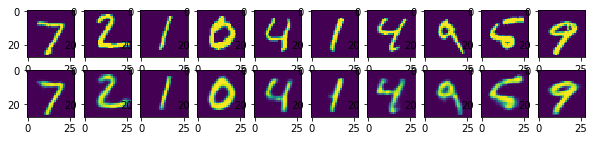

In [12]:
# Initializing the variables
merged = tf.summary.merge_all()
init = tf.global_variables_initializer()

if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)

saver = tf.train.Saver()
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    train_writer = tf.summary.FileWriter(log_dir + '/summaries/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/summaries/test')

    total_batch = int(mnist.train.num_examples/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) adn cost op (to get loss value)
            summary, _, c = sess.run([merged, optimizer, cost], feed_dict={X: batch_xs})
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
            sys.stdout.flush()
        train_writer.add_summary(summary, epoch)
    print("Optimization Finished!")
    train_writer.close()
    test_writer.close()
    saver.save(sess, log_dir + "model/my_model")

    # Applying encode and decode over test set
    encode_decode = sess.run(y_pred,
                             feed_dict={X: mnist.test.images[:examples_to_show]})
    # Compare original images with their reconstructions
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    f.show()

sess.close()

## クラスタリング

中間層の出力をTensorboardでクラスタリングしてみます。

In [25]:
import os
from tensorflow.contrib.tensorboard.plugins import projector

In [26]:
n_data = 10000

#init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, log_dir + "model/my_model") # not shown
    batch_xs, batch_ys = mnist.test.next_batch(n_data)
    hidden = sess.run(coding_op, feed_dict={X: batch_xs})
    hidden_mean = sess.run(coding_mean, feed_dict={X: batch_xs})

INFO:tensorflow:Restoring parameters from ./my_model


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./my_model
	 [[Node: save_5/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save_5/Const_0_0, save_5/RestoreV2/tensor_names, save_5/RestoreV2/shape_and_slices)]]
	 [[Node: save_5/RestoreV2/_81 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_176_save_5/RestoreV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save_5/RestoreV2', defined at:
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-06eab05eaf4c>", line 4, in <module>
    saver = tf.train.Saver()
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1139, in __init__
    self.build()
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1170, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 640, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/a1021028/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./my_model
	 [[Node: save_5/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save_5/Const_0_0, save_5/RestoreV2/tensor_names, save_5/RestoreV2/shape_and_slices)]]
	 [[Node: save_5/RestoreV2/_81 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_176_save_5/RestoreV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [21]:
hidden_mean

array([[-0.28738695,  0.30313328, -0.11015311, ..., -1.16592741,
        -0.0133209 ,  0.24648175],
       [-1.41768348,  0.43386692, -1.85157895, ...,  0.26582742,
        -0.29927453, -0.80946398],
       [-0.84023643,  0.0174911 , -0.47468168, ...,  0.71053821,
        -0.70165473,  0.88127691],
       ..., 
       [ 0.19201279,  0.41554725, -0.8835907 , ...,  1.72696555,
        -1.00333214, -0.66721904],
       [-0.89550412,  1.14694214, -1.70604908, ..., -0.60136235,
        -0.35393098,  0.78778672],
       [-0.7568565 , -0.5854131 ,  0.24616061, ..., -0.24207674,
        -0.57763982, -0.12545434]], dtype=float32)

### メタデータファイルの作成

In [22]:
# 
#LOG_DIR = "/tmp/tensorflow/variational_AE_MNIST/logs"

# recreate log directory
if tf.gfile.Exists(log_dir + '/projector'):
    tf.gfile.DeleteRecursively(log_dir + '/projector')
tf.gfile.MakeDirs(log_dir + '/projector')

In [23]:
ys = batch_ys
with open(os.path.join(log_dir, 'projector/metadata.tsv'),'w') as f:
    #f.write("Index\tLabel\n")
    for index, label in enumerate(ys):
        label = int(np.where(label == 1)[0])   ## one-hot to index
        f.write('{}\n'.format(label))

### クラスタ用のembeddingを保存

In [24]:
xs = tf.stack(hidden_mean, axis=0)

with tf.variable_scope('hidden_embedding'):
    embedding_var = tf.Variable(xs, trainable=False, name='embedding')


summary_writer = tf.summary.FileWriter(os.path.join(log_dir, 'projector'), sess.graph)

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# metadata 
embedding.metadata_path = os.path.join(log_dir, 'projector/metadata.tsv')

# stripe 
#embedding.sprite.image_path = os.path.join(LOG_DIR, 'sprite_image.png')
#embedding.sprite.single_image_dim.extend([28,28])

projector.visualize_embeddings(summary_writer, config)


#sess = tf.InteractiveSession()

# initialize "embedding_ver"
init = tf.variables_initializer([embedding_var])

with tf.Session() as sess:
    sess.run(init)
    # specify variable to save 
    saver = tf.train.Saver([embedding_var])
    # save variables 
    saver.save(sess, os.path.join(log_dir, "projector/model.ckpt"), global_step=n_data)

## Generate digits

In [13]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

# Initializing the variables
merged = tf.summary.merge_all()
init = tf.global_variables_initializer()

if tf.gfile.Exists(log_dir):
    tf.gfile.DeleteRecursively(log_dir)
tf.gfile.MakeDirs(log_dir)

with tf.Session() as sess:
    init.run()
    train_writer = tf.summary.FileWriter(log_dir + '/summaries/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/summaries/test')
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()  
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(optimizer, feed_dict={X: X_batch})
        summary, loss_val, reconstruction_loss_val, latent_loss_val = sess.run([merged, cost, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) 
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown    
        train_writer.add_summary(summary, epoch)
        
        codings_rnd = np.random.normal(size=[n_digits, n_hidden_coding])
        outputs_val = y_pred.eval(feed_dict={coding_op: codings_rnd})
        
    train_writer.close()
    test_writer.close()

0 Train total loss: 39003.5 	Reconstruction loss: 24746.2 	Latent loss: 14257.2
1 Train total loss: 33304.0 	Reconstruction loss: 26539.2 	Latent loss: 6764.78
2 Train total loss: 25684.4 	Reconstruction loss: 21760.1 	Latent loss: 3924.35
3 Train total loss: 22355.3 	Reconstruction loss: 19143.1 	Latent loss: 3212.25
4 Train total loss: 27859.5 	Reconstruction loss: 21472.4 	Latent loss: 6387.15
5 Train total loss: 19259.1 	Reconstruction loss: 16062.2 	Latent loss: 3196.91
6 Train total loss: 17922.7 	Reconstruction loss: 14869.7 	Latent loss: 3053.01
7 Train total loss: 17895.9 	Reconstruction loss: 14591.7 	Latent loss: 3304.21
8 Train total loss: 16756.8 	Reconstruction loss: 13636.0 	Latent loss: 3120.75
9 Train total loss: 16550.9 	Reconstruction loss: 13419.7 	Latent loss: 3131.18
10 Train total loss: 16436.9 	Reconstruction loss: 13212.8 	Latent loss: 3224.11
11 Train total loss: 17302.1 	Reconstruction loss: 14013.5 	Latent loss: 3288.53
12 Train total loss: 16707.1 	Reconstr

In [14]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

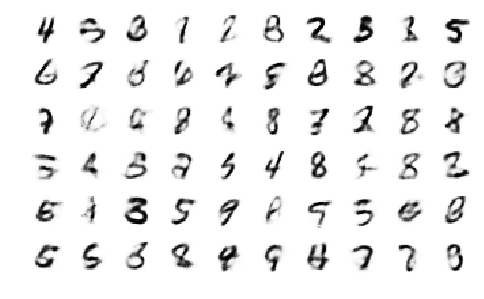

In [15]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])